# Pair-trading With Cryptos Part 2

## How To Implement A Pair-trading Strategy Using Python

## Introduction

Cryptocurrencies (or cryptos) captured the world's imagination during the last couple of years. From their spectacular rise in 2017, to their equally hard fall in 2018, and to their most recent revival this year. Cryptocurrencies and the blockchain engine powering them are regarded as disruptive forces proposing an alternative decentralized monetary system. They also garnered their fair share of criticism. Cryptocurrencies are accused of facilitating transfer of "dirty money" between criminals. For a while cryptocurrencies provided dizzying returns and earned the reputation of being a "get rich quick" scheme.

In this article, we focus on cryptocurrencies as investment vehicles sharing common features with FX, commodities and precious metals. Both crypto and fiat currencies allow for wealth transfer. Cryptocurrencies are similar to commodities because both have limited supply. They also draw comparisons to gold which is viewed in investment circles as "safe-haven" investment. 

Recall in the previous article, I illustrated how to source cryptocurrency historical data from the web. In this article, I will present how to backest a pair-trading strategy using the collected dataset.

## Implementing A Pair-trading Strategy
We implement a trading strategy inspired from [E. Chan's pair-trading strategy](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889/ref=sr_1_3?keywords=ernest+chan&qid=1559220592&s=gateway&sr=8-3) involving gold and gold miners ETFs. After money is injected to traditional markets like equity and fixed-income, it will eventually overflow into alternative asset classes like cryptocurrencies. We suppose that money flowing to cryptocurrencies will drive their prices together.

The price movement between two cryptocurrencies is measured by the difference in their prices or spread.
If the spread between is mean-reverting, then we can implement a contrarian strategy.
We have the following rules for our pair-trading strategy:
- Enter a long position on the spread if it is below -1 STD.
- Enter a short position on the spread if it is above 1 STD.
- Exit the position if the spread is greater than -0.5 and less than 0.5 STD.

### Step By Step
1. Load the historical data.
2. Implement and backtest the trading strategy.
3. Analyze the performance of the pair-trading strategy.

You can find the code on https://github.com/DinodC/pair-trading-cryptos.

Import packages

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

## Load Data

Load the historical data

In [2]:
with open('data_coinmarketcap.pickle', 'rb') as f:
    data = pickle.load(f)
    
f.close()

Create close prices DataFrame object

In [3]:
close = pd.DataFrame({'BTC': data.BTC.Close,
                      'ETH': data.ETH.Close,
                      'LTC': data.LTC.Close,
                      'XRP': data.XRP.Close})

Truncate historical data

In [4]:
close = close[:-100]

Create an id for Bitcoin, Ethereum, Litecoin and Ripple cryptocurrencies to USD.

In [5]:
id = ['BTC', 'ETH', 'LTC', 'XRP']

Plot the close crypto-to-fiat prices

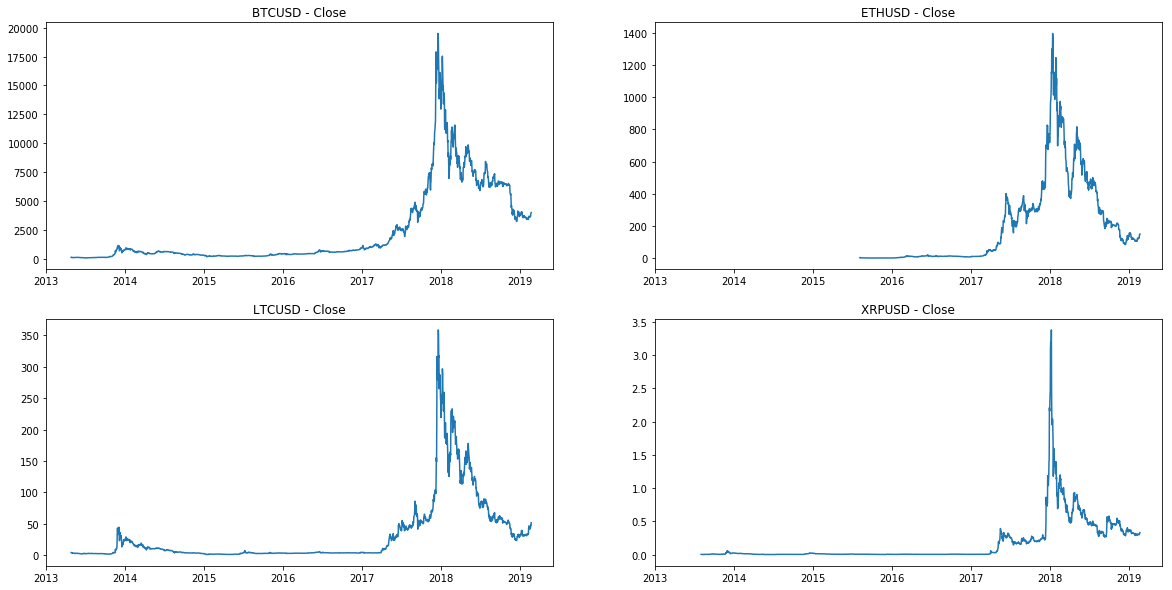

In [6]:
plt.figure(figsize=[20, 10])

for i in range(1, len(id)+1):    
    plt.subplot(2, 2, i)
    plt.plot(close[id[i-1]])
    plt.title(id[i-1] + 'USD - Close')
    plt.xlim('2013-01-01', '2019-06-01')


Note that ETHUSD prices are only available from July 2015 because Ethereum was only released during this time.

## Pair-trading Strategy Implementation
Before implementing the pair-trading strategy, recall in a previous article the things to look out for when backtesting:
1. Data-snooping bias
2. Look-ahead bias
3. Transaction costs

I will review these pitfalls and propose solutions to mitigate their effect on the backtesting results.

### Correcting For Data-snooping Bias
Data-snooping is the use of data analysis to find statistically significant patterns when in fact they are not.
It can originate from overfitting the model to a dataset by increasing the number of its parameters.
Data-snooping can also come from optimizing trading decisions e.g. choosing entry and exit thresholds.

To mitigate data-snooping bias, we can do the following:
1. Out-of-sample testing: 
Out-of-sample testing involves separating historical data into a training and testing set. 
We optimize the model's parameters using the training set, and validate it on the testing or out-of-sample set.
2. Paper trading:
Paper trading share the same idea as out-of-sample testing in separating the dataset. 
We optimize the model's parameters using the historical data, and run it using incoming actual data. 

In this article, we apply out-of-sample testing by dividing the data into two equal sets.

In [7]:
# Define training set
training_start = '2015-08-07'
training_end = '2017-08-01'
training_set = close[training_start:training_end]

# Define testing set
testing_start = '2017-08-02'
testing_end = '2019-05-21'
testing_set = close[testing_start:testing_end]

### Correcting For Look-ahead Bias
Look-ahead bias is the use of information not yet available at the moment the trade was recommended. An example is calculating the trading signal based on the day's highest or lowest price. As the day's high and low are only available at close, we correct this by lagging our historical data.

Another way to mitigate look-ahead bias is the following check:
1. Backtest using historical data and save the positions.
2. Backtest using truncated historical data, e.g. 10 days, and save the positions.
3. Truncate the positions from point 1, e.g. 10 days, compare with the positions from point 2.

Note that the implementation of this check is just after the backtesting.

### Including Transaction Costs
Transaction costs make the backtest more realistic. 
They deflate a trading strategy's performance by including the following:
1. Slippage is the difference between your expected price and the executed price.
2. Commission fee is a service charge extracted by your broker for handling your purchases.
3. Market impact is the price effect you genereate each time you pass a considerable order to the market.

In this article, we assume a round-trip transaction cost of 10 BPs per trade. 

In [8]:
round_trip = 0.0010

### Implementation

We define the entry and exit thresholds

In [9]:
entry_threshold = 1
exit_threshold = 0.5

We implement the pair-trading strategy

In [10]:
# Set crypto 1 to BTC
crypto_1 = id[0]

# Initialize output
output = {id[1]: {},
          id[2]: {}, 
          id[3]: {}}

for i in range(1, len(id)):
    
    # Set crypto 2 to ETH, LTC and XRP
    crypto_2 = id[i]
    
    # Calculate the hedge ratio using the training set
    model = sm.OLS(training_set[crypto_1], training_set[crypto_2])
    result = model.fit()
    hedge_ratio = result.params[crypto_2]

    # Calculate the spread
    spread = close[crypto_1] - hedge_ratio * close[crypto_2]
    # Mean of the spread on the training set
    spread_mean = spread[training_start:training_end].mean()
    # Standard deviation of the spread calculated on the training set
    spread_std = spread[training_start:training_end].std()
    # Z-score of the spread
    z_score = (spread - spread_mean) / spread_std
    
    # Implement pair trading strategy
    # Create masks for long, short and exit positions
    longs = (z_score <= -entry_threshold)
    shorts = (z_score >= entry_threshold)
    exits = (np.abs(z_score) <= exit_threshold)
    # Initialize the positions
    positions = pd.DataFrame({crypto_1: np.nan * pd.Series(range(len(z_score))),
                              crypto_2: np.nan * pd.Series(range(len(z_score)))},
                             index=z_score.index)
    # Update the positions
    [positions[crypto_1][longs], positions[crypto_2][longs]] = [1, -1]
    [positions[crypto_1][shorts], positions[crypto_2][shorts]] = [-1, 1]
    [positions[crypto_1][exits], positions[crypto_2][exits]] = [0, 0]
    # Carry foward the positions except when there is an exit
    positions.fillna(method='ffill', inplace=True)
    # Lag the positions to the next day because we base calculations on close
    positions = positions.shift(periods=1)
    
    # Calculate the performance
    # Initialize the returns
    returns = pd.DataFrame({crypto_1: close[crypto_1],
                            crypto_2: close[crypto_2]})
    # Update the returns
    returns = returns.pct_change()
    # Calculate the pnl
    pnl = returns * positions

    # Calculate transaction costs
    # Create a mask to indicate changes in position
    mask = (~np.isnan(positions.BTC) & (positions.BTC - positions.BTC.shift(periods=1)).astype(bool))
    # mask = (~np.isnan(positions.BTC) & (positions.BTC != positions.BTC.shift(periods=1)))
    # Create a transaction costs Series
    tc = pd.Series(np.zeros(len(mask)), index=mask.index)
    tc[mask] = - round_trip
    
    # Update pnl DataFrame
    pnl['TC'] = tc
    # Calculate net pnl
    pnl_net = pnl.sum(axis='columns')
    
    # Calculate the Sharpe ratio under the training set
    sharpe_training = np.sqrt(252) * pnl_net[training_start:training_end].mean() / pnl_net[training_start:training_end].std()
    # Calculate the Sharpe ratio under the testing set
    sharpe_testing = np.sqrt(252) * pnl_net[testing_start:testing_end].mean() / pnl_net[testing_start:testing_end].std()
            
    # Generate the output
    # Gather data
    data = {'spread': z_score,
            'positions': positions,
            'pnl': pnl_net,
            'sharpe training': sharpe_training,
            'sharpe testing': sharpe_testing,
           }
    # Update the output
    output.update({crypto_2: data})
    

### Check For Look-ahead Bias

Save the output generated using the truncated historical data

In [11]:
with open('output_truncated.pickle', 'wb') as f:
    pickle.dump(output, f)
    
f.close()

## Performance Analysis

### Spread
Recall that the spread between BTC and other cryptocurrencies provides the signal of our trading strategy.

Plot the spread

(-50, 50)

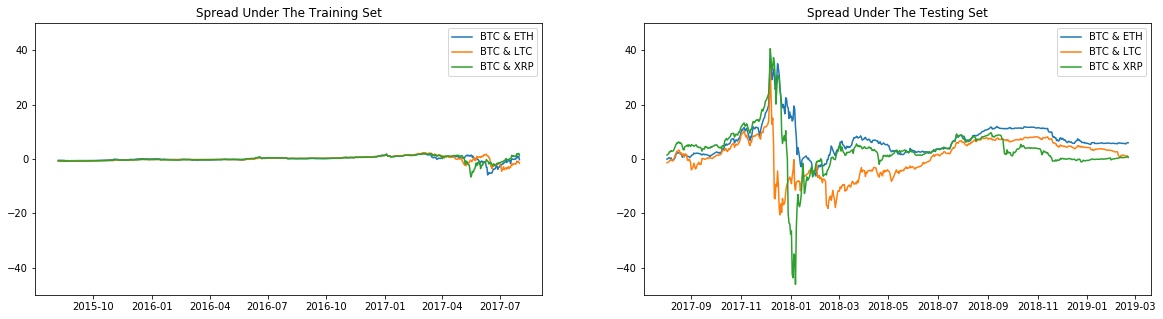

In [12]:
plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(output['ETH']['spread'][training_start:training_end])
plt.plot(output['LTC']['spread'][training_start:training_end])
plt.plot(output['XRP']['spread'][training_start:training_end])
plt.title('Spread Under The Training Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-50, 50)

plt.subplot(1, 2, 2)
plt.plot(output['ETH']['spread'][testing_start:testing_end])
plt.plot(output['LTC']['spread'][testing_start:testing_end])
plt.plot(output['XRP']['spread'][testing_start:testing_end])
plt.title('Spread Under The Testing Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-50, 50)

Remarks:
1. On the training set, the spread between BTC and other cryptocurrencies is flat except for January to July 2017 where it exhibited mean-reversion.
2. On the testing set, the spread between BTC and other cryptocurrencies shot up at the end of 2017 before falling down at the start of 2018.
3. Comparing the spread under the training and testing sets, there seem to be two different underlying processes i.e. a regime change.

### Sharpe Ratio

Create Sharpe ratio table

In [13]:
sharpe = pd.DataFrame({'BTC & ETH': [output['ETH']['sharpe training'], output['ETH']['sharpe testing']],
                       'BTC & LTC': [output['LTC']['sharpe training'], output['LTC']['sharpe testing']],
                       'BTC & XRP': [output['XRP']['sharpe training'], output['XRP']['sharpe testing']]},
                      index=pd.MultiIndex.from_product([['Sharpe Ratio'], ['Training Set', 'Testing Set']]))

In [14]:
sharpe

BTC & ETH  BTC & LTC  BTC & XRP
Sharpe Ratio Training Set   1.817663   1.175902   1.272301
             Testing Set   -0.138531   0.795942   0.673426

Remarks:
1. On the training set, trading pairs BTC & ETH, BTC & LTC and BTC & XRP generated good Sharpe ratios, higher than 1.
2. On the testing set, the pair-trading strategy generated lower Sharpe ratios than the training set.
3. Performance degradation in the testing set is caused by the spread's regime change.

### PnL

Plot the cumulative pnl

(-1, 10)

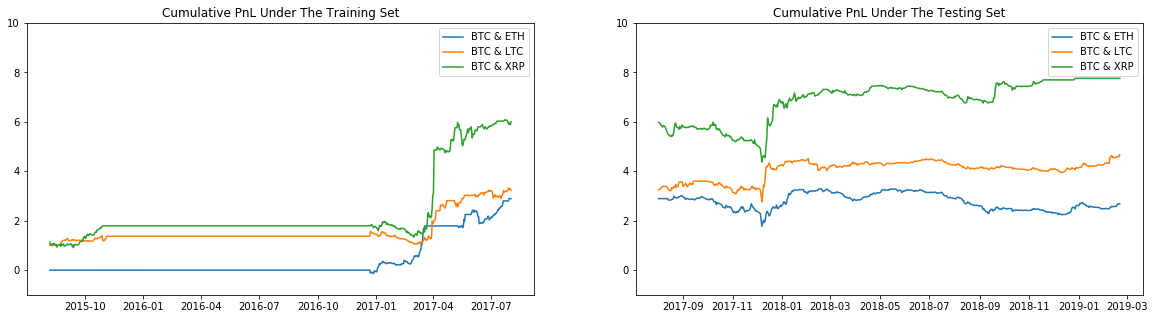

In [15]:
plt.figure(figsize=[20, 5])

plt.subplot(1, 2, 1)
plt.plot(output['ETH']['pnl'].cumsum()[training_start:training_end])
plt.plot(output['LTC']['pnl'].cumsum()[training_start:training_end])
plt.plot(output['XRP']['pnl'].cumsum()[training_start:training_end])
plt.title('Cumulative PnL Under The Training Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-1, 10)

plt.subplot(1, 2, 2)
plt.plot(output['ETH']['pnl'].cumsum()[testing_start:testing_end])
plt.plot(output['LTC']['pnl'].cumsum()[testing_start:testing_end])
plt.plot(output['XRP']['pnl'].cumsum()[testing_start:testing_end])
plt.title('Cumulative PnL Under The Testing Set')
plt.legend(['BTC & ETH', 'BTC & LTC', 'BTC & XRP'])
plt.ylim(-1, 10)

Remarks:
1. On the training set, trading pairs BTC & ETH, BTC & LTC and BTC & XRP made profits from January to July 2017.
2. On the test set, pair-trading strategy generated small profits during fall in January 2018.
3. Lower profits in the testing set is consistent with the previous remarks.

## Conclusion
In this article, we implemented and backtested a pair-trading strategy using cryptocurrencies such as BTC, ETH, LTC and XRP. We limited data-snooping in our backtest by applying out-of-sample testing. We mitigated look-ahead bias by truncating the historical data. Transaction costs were included in the backtest to make it closer to reality.